In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer,make_column_selector
from sklearn.pipeline import Pipeline
import joblib

Improt the dataset

In [2]:
#setup display options
pd.set_option('display.max_columns', None)
pd.set_option('display.min_rows', 15)
df = pd.read_csv("..\data\data_cleaned.csv",index_col=[0])


In [3]:
df.head()

,id,type of property,subtype of property,locality,latitude,longitude,street,postalCode,price,type of sale,number of bedrooms,living area,livable area,fully equipped kitchen,furnished,open fire,terrace,terrace area,garden,garden area,total property area,total land area,number of facades,swimming pool,state of the building,Gemeente,Province,Population,Area(km2),Density,kitchen,price per sqr
0,10689265,HOUSE,MIXED_USE_BUILDING,Koekelberg,50.863091,4.329928,Rue du Noyer 86,1081,575000.0,residential_sale,3,0,220.0,installed,False,False,True,0.0,False,0.0,220.0,71.0,2.0,False,good,Koekelberg,Brussel,1208542.0,162.4,7442.0,NaN,2613.636364
1,10687297,HOUSE,EXCEPTIONAL_PROPERTY,Beveren,51.224437,4.246054,NaN,9120,695000.0,residential_sale,4,28,269.0,hyper_equipped,False,False,True,41.0,True,300.0,269.0,583.0,3.0,False,as_new,Beveren,Oost-Vlaanderen,1515064.0,3007.0,504.0,Hyper equipped,2583.643123
2,10686031,HOUSE,HOUSE,Seraing,50.598224,5.518784,Place Merlot 6,4100,144000.0,residential_sale,2,14,105.0,semi_equipped,False,False,True,0.0,True,25.0,105.0,105.0,2.0,False,good,Seraing,Liège,1106992.0,3857.0,288.0,Semi equipped,1371.428571
3,10686030,HOUSE,HOUSE,Seraing,50.601548,5.510799,Place Merlot 6,4100,199000.0,residential_sale,4,25,125.0,installed,False,False,True,108.0,True,28.0,125.0,229.0,2.0,False,good,Seraing,Liège,1106992.0,3857.0,288.0,NaN,1592.000000
4,10686027,HOUSE,VILLA,Herzele,50.891145,3.857915,Hoogstraat 20,9550,539000.0,residential_sale,4,65,370.0,hyper_equipped,False,False,True,60.0,False,0.0,370.0,911.0,4.0,False,as_new,Herzele,Oost-Vlaanderen,1515064.0,3007.0,504.0,Hyper equipped,1456.756757


In [4]:
df["kitchen"].value_counts()

kitchen
Hyper equipped    2328
Semi equipped     1859
Not equipped       675
Equipped           410
Name: count, dtype: int64

Data cleaning!
1. fillna
2. remove castles
3. scaling certain data
4. get dummies


In [5]:
#drop Nan rows
df["kitchen"]=df["kitchen"].fillna("Not equipped ")

#remove castles
castle = df[df["subtype of property"]=="CASTLE"].index
df.drop(castle,inplace=True)

def convert(n):
    return int(n/100)
df["digit"]=df["postalCode"].agg(convert)


In [6]:

#get dummies for catagorical data:
# get_dummies = ["Province","type of property","kitchen","subtype of property","state of the building","garden","terrace","digit"]
# df =pd.get_dummies(data=df, columns=get_dummies)

df.drop(columns=["fully equipped kitchen"],inplace=True)

#replace True with 1, and False with 0, turn them into numerical data
df.replace([True,False,"Liège"],[1,0,"Liege"],inplace=True)


In [7]:
df.shape

(15660, 32)

Remove outliners and castles

In [8]:
def remove_outliners(df,columns,n_std):
    for col in columns:

        mean = df[col].mean()
        sd = df[col].std()
        df = df[(df[col] <= mean+(n_std*sd))]
        df = df[(df[col] >= mean-(n_std*sd))]

    return df

# def remove_outliner(df, col_names):
#     for col_name in col_names:
#         q1 = df[col_name].quantile(0.25)
#         q3 = df[col_name].quantile(0.75)
#         iqr = q3-q1 #Interquartile range
#         fence_low  = q1-1.5*iqr
#         fence_high = q3+1.5*iqr
#         df = df.loc[(df[col_name] > fence_low) & (df[col_name] < fence_high)]

#     return df



In [9]:
# print(df["price"].std())
# print(df["price"].mean())
df = remove_outliners(df, ["number of bedrooms","livable area","living area",
                           "total property area","garden area","total land area","terrace area","price"],3)
#change the building-state description
df["state of the building"].replace(['good', 'as_new', 'to_be_done_up', 
                                       'to_renovate', 'to_restore',
                                       'just_renovated', '0'],
                                       ["GOOD","NEW","TO RENOVATE","TO RENOVATE","TO REBUILD"
                                        ,"JUST RENOVATED",0],
                                       inplace=True)
df = df.drop(df[df["state of the building"]==0].index)
df.shape

(11976, 32)

In [10]:
df.head()

,id,type of property,subtype of property,locality,latitude,longitude,street,postalCode,price,type of sale,number of bedrooms,living area,livable area,furnished,open fire,terrace,terrace area,garden,garden area,total property area,total land area,number of facades,swimming pool,state of the building,Gemeente,Province,Population,Area(km2),Density,kitchen,price per sqr,digit
0,10689265,HOUSE,MIXED_USE_BUILDING,Koekelberg,50.863091,4.329928,Rue du Noyer 86,1081,575000.0,residential_sale,3,0,220.0,0,0,1,0.0,0,0.0,220.0,71.0,2.0,0,GOOD,Koekelberg,Brussel,1208542.0,162.4,7442.0,Not equipped,2613.636364,10
1,10687297,HOUSE,EXCEPTIONAL_PROPERTY,Beveren,51.224437,4.246054,NaN,9120,695000.0,residential_sale,4,28,269.0,0,0,1,41.0,1,300.0,269.0,583.0,3.0,0,NEW,Beveren,Oost-Vlaanderen,1515064.0,3007.0,504.0,Hyper equipped,2583.643123,91
2,10686031,HOUSE,HOUSE,Seraing,50.598224,5.518784,Place Merlot 6,4100,144000.0,residential_sale,2,14,105.0,0,0,1,0.0,1,25.0,105.0,105.0,2.0,0,GOOD,Seraing,Liege,1106992.0,3857.0,288.0,Semi equipped,1371.428571,41
4,10686027,HOUSE,VILLA,Herzele,50.891145,3.857915,Hoogstraat 20,9550,539000.0,residential_sale,4,65,370.0,0,0,1,60.0,0,0.0,370.0,911.0,4.0,0,NEW,Herzele,Oost-Vlaanderen,1515064.0,3007.0,504.0,Hyper equipped,1456.756757,95
5,10686410,HOUSE,HOUSE,Forest,50.821444,4.323519,NaN,1190,650000.0,residential_sale,4,16,215.0,0,0,1,10.0,1,90.0,215.0,170.0,2.0,0,TO RENOVATE,Forest,Brussel,1208542.0,162.4,7442.0,Not equipped,3023.255814,11


Data formatting: 
1.normalize the data
2.create X,y, split them into training and testing

In [11]:
# # fix the distributions of number of bedrooms
# df["number of bedrooms"] = np.log(df["number of bedrooms"] + 1)

#normalize these columns
columns_to_normalize = ["latitude","longitude","living area","livable area",
                        "garden area","total property area","total land area","number of facades","number of bedrooms","terrace area"]

# print(df["price"].sort_values())

In [12]:
# price would be the target
columns_to_drop = ["id","locality","street","price","type of sale"
                   ,"Density","Area(km2)",
                   "Population","price per sqr","open fire","postalCode","Gemeente",
                   "livable area","latitude","longitude","subtype of property"]
#Now normalize the data)
y = df.loc[:,"price"].to_numpy().reshape(-1,1)
# scale the data
X=df.drop(columns=columns_to_drop,axis=1)
column_list = []
for column in X.columns:
    column = column.replace(" ","_")
    column_list.append(column)
X.columns = column_list
print(X.columns)
X = X.to_numpy()


# X=preprocessing.normalize(X_raw) 
# print(X.shape,y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2,random_state=21)


Index(['type_of_property', 'number_of_bedrooms', 'living_area', 'furnished',
       'terrace', 'terrace_area', 'garden', 'garden_area',
       'total_property_area', 'total_land_area', 'number_of_facades',
       'swimming_pool', 'state_of_the_building', 'Province', 'kitchen',
       'digit'],
      dtype='object')


In [13]:
print(X.shape, X_train.shape, y_train.shape)


(11976, 16) (9580, 16) (9580, 1)


visualization of the raw_data

In [14]:
df.drop(columns=columns_to_drop,axis=1).head()

,type of property,number of bedrooms,living area,furnished,terrace,terrace area,garden,garden area,total property area,total land area,number of facades,swimming pool,state of the building,Province,kitchen,digit
0,HOUSE,3,0,0,1,0.0,0,0.0,220.0,71.0,2.0,0,GOOD,Brussel,Not equipped,10
1,HOUSE,4,28,0,1,41.0,1,300.0,269.0,583.0,3.0,0,NEW,Oost-Vlaanderen,Hyper equipped,91
2,HOUSE,2,14,0,1,0.0,1,25.0,105.0,105.0,2.0,0,GOOD,Liege,Semi equipped,41
4,HOUSE,4,65,0,1,60.0,0,0.0,370.0,911.0,4.0,0,NEW,Oost-Vlaanderen,Hyper equipped,95
5,HOUSE,4,16,0,1,10.0,1,90.0,215.0,170.0,2.0,0,TO RENOVATE,Brussel,Not equipped,11


In [15]:
df["state of the building"].unique()

array(['GOOD', 'NEW', 'TO RENOVATE', 'TO REBUILD', 'JUST RENOVATED'],
      dtype=object)

In [16]:
df.drop(columns=columns_to_drop,axis=1)["kitchen"].value_counts()

kitchen
Not equipped      7609
Hyper equipped    1800
Semi equipped     1655
Not equipped       561
Equipped           351
Name: count, dtype: int64

Using Columntransformer for pipeline OHE

In [17]:
trans_1 = ColumnTransformer([('ohe_trans',OneHotEncoder(sparse_output=False, handle_unknown='ignore'), [0,12,13,14,15])], remainder='passthrough' )

Using Columntransformer for pipeline scaling

In [18]:
trans_2 = ColumnTransformer([('scale', MinMaxScaler(),slice(0,len(X)))], remainder='passthrough')

Model selection :Linear Regression

0.6216379288776885
0.6167164342984859


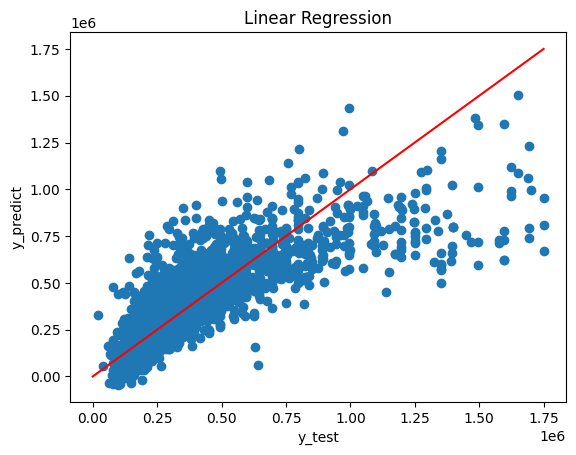

In [19]:
reg = LinearRegression()
pipe = Pipeline([('trans_1',trans_1),
                 ("trans_2",trans_2),
                 ('trans_3',reg)])

pipe.fit(X_train, y_train)
print(pipe.score(X_train,y_train))
print(pipe.score(X_test,y_test))
y_pred = pipe.predict(X_test)

#show result
a = np.array([0,max(y_test)[0]])
plt.scatter(y_test,y_pred)
plt.plot(a,a,color="red")
plt.xlabel("y_test")
plt.ylabel("y_predict")
plt.title("Linear Regression")
plt.show()

Decision Tree?


0.7485344763704869
0.639511259146291


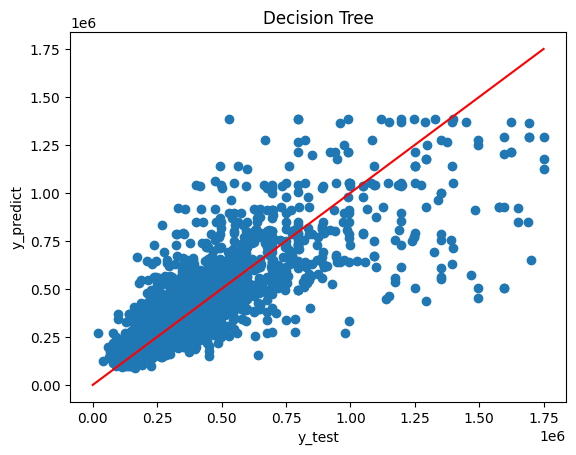

In [20]:
from sklearn.tree import DecisionTreeRegressor
import pickle

#depth, minimum samples, and minimum sample split. 
#These values can be tuned to ensure that we are able to achieve early stopping.
clf = DecisionTreeRegressor(min_samples_leaf=10,max_features=0.9)
pipe = Pipeline([('trans_1',trans_1),
                 ("trans_2",trans_2),
                 ('trans_3',clf)])

pipe.fit(X_train, y_train)
print(pipe.score(X_train,y_train))
print(pipe.score(X_test,y_test))
y_pred = pipe.predict(X_test)
#show result
a = np.array([0,max(y_test)[0]])
plt.scatter(y_test,y_pred)
plt.plot(a,a,color="red")
plt.xlabel("y_test")
plt.ylabel("y_predict")
plt.title("Decision Tree")
plt.show()

# test = {
#   "type_of_property": "HOUSE",
#   "subtype_of_property": "VILLA",
#   "number_of_bedrooms": 2,
#   "living_area":60,
#   "furnished": 0,
#   "terrace": 0,
#   "terrace_area": 0,
#   "garden": 1,
#   "garden_area": 20,
#   "total_property_area": 120,
#   "total_land_area": 300,
#   "number_of_facades": 2,
#   "swimming_pool": 0,
#   "state_of_the_building": "GOOD",
#   "Province": "Oost-Vlaanderen",
#   "kitchen": "Not equipped",
#   "postalcode": 9000
# }
# def _convert(n):
#     return int(n/100)
# df1 = pd.DataFrame(test)
#   #take the first two digits of postalcode
# df1["postalcode"]=df["postalcode"].agg(_convert)
# df1.replace([True, False],[1,0])
# df1.rename(columns={"postalcode":"digit"},inplace=True)
# Xx=df1.to_numpy()
# yy_pred = pipe.predict(Xx)
# print(yy_pred)

Applying hyperparament tunning to the decision tree model

In [21]:

def single_grid_search(X_train, y_train):
    """
    Performs a grid search using the training set given.
    """
    # Setting all the parameters we want to test
    """params = {
        'max_features' : np.arange(0.1,1,0.1).tolist(), #Number of features to consider as a fraction of all features
        'max_depth': [1,2,4,8, None],# Depth of the tree
    "min_samples_leaf":[1,2,4,8,10]
    }

    gridsearch = GridSearchCV(estimator = clf,
                            param_grid = params,
                            cv = 5, # Use 5 folds
                            verbose = 0,
                            n_jobs = -1 #Use all but one CPU core
                            )
    return gridsearch.fit(X_train, y_train)

result = single_grid_search(X_train, y_train)
decision_tree = result.best_estimator_
score = decision_tree.score(X_test, y_test)
print("The generalization accuracy of the model is {:.2f}%".format(score * 100))"""

In [22]:
# Now we can create k train-test splits using KFold
from sklearn.model_selection import KFold

# Using KFold instead of calling multiple times train_test_split to ensure that each
# sample goes into a single split only
"""kf = KFold(n_splits=5, random_state=45, shuffle=True)

split = 0
scores = []
for train_index, test_index in kf.split(X,y):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    result = single_grid_search(X_train, y_train)
    
    decision_tree = result.best_estimator_
    score = decision_tree.score(X_test, y_test)
    scores.append(score)
    print("### Split {}: Accuracy is {:.2f}% ###".format(split := split + 1, score*100))"""

'kf = KFold(n_splits=5, random_state=45, shuffle=True)\n\nsplit = 0\nscores = []\nfor train_index, test_index in kf.split(X,y):\n    \n    X_train, X_test = X[train_index], X[test_index]\n    y_train, y_test = y[train_index], y[test_index]\n    \n    result = single_grid_search(X_train, y_train)\n    \n    decision_tree = result.best_estimator_\n    score = decision_tree.score(X_test, y_test)\n    scores.append(score)\n    print("### Split {}: Accuracy is {:.2f}% ###".format(split := split + 1, score*100))'

Try XGboost

In [23]:
#use XGBregressor! instead of XGBclassifier!!
from xgboost import XGBRegressor
model= XGBRegressor()
pipe = Pipeline([('trans_1',trans_1),
                 ("trans_2",trans_2),
                 ('trans_3',model)])

pipe.fit(X_train, y_train)

filename = "XGB.joblib"
joblib.dump(pipe,filename)
another_file = "XGBpickle.pickle"
pickle.dump(pipe, open(another_file, "wb"))


# print(pipe.score(X_train,y_train))
# print(pipe.score(X_test,y_test))
# y_pred = pipe.predict(X_test)

# #show result
# a = np.array([0,max(y_test)[0]])
# plt.scatter(y_test,y_pred)
# plt.plot(a,a,color="red")
# plt.xlabel("y_test")
# plt.ylabel("y_predict")
# plt.title("XGBoost")
# plt.show()

Random Forest

c:\Users\spike\Documents\study\becode_projects\Real_Estate_Analysis\immovenv\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.9499549687939614
0.6993394340788932


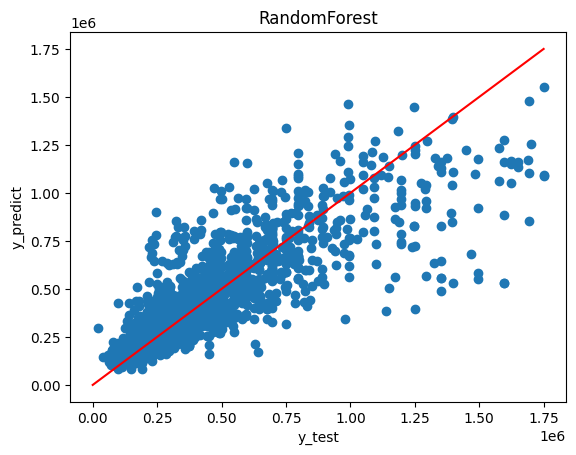

In [24]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(n_estimators=20)
pipe = Pipeline([('trans_1',trans_1),
                 ("trans_2",trans_2),
                 ('trans_3',reg)])

pipe.fit(X_train, y_train)
print(pipe.score(X_train,y_train))
print(pipe.score(X_test,y_test))
y_pred = pipe.predict(X_test)

#show result
a = np.array([0,max(y_test)[0]])
plt.scatter(y_test,y_pred)
plt.plot(a,a,color="red")
plt.xlabel("y_test")
plt.ylabel("y_predict")
plt.title("RandomForest")
plt.show()